In [1]:
import os
os.chdir('/home/david/Projects/optogenetic_whole_cell_activation/morph_impact_on_opt_stim')
import numpy as np
import pandas as pd
from neuron import h
from neurostim.cell import Cell
from neurostim.light_classes import LightSource, LightStimulation
from neurostim.utils import convert_polar_to_cartesian_xz, interpolate
from neurostim.polarmaps import get_AP_times
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial'],'size':8})

In [2]:
# format
# dimensions (A4:  8.27 x 11.69 inches)
text_frac = 0.8
abs_pw = 8.27 # pagewidth
abs_pl = 11.69 # pagelength
pw = text_frac * abs_pw
pl = text_frac * abs_pl
# others
dpi=600

In [3]:
# simulate conductances in L5 cell for selected light powers
hoc_file = 'L5'
plot_path = 'paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/'+hoc_file+'_'

#light_powers = [5e-5, 1e-4, 5e-4, 1e-3, 5e-3]
light_powers = np.exp(np.linspace(np.log(1e-4), np.log(1e-2),10))
light_powers = np.linspace(1e-5, 1e-2,200)

In [4]:
# model config 1 ---- *** DO NOT RERUN ***
# NEURON simulator setup is corrupted if reinitialized in a running kernel, rerun complete notebook

# cortical depth of neuron models
cortical_depth = {'L23': 400, 'L5': 1170} #um

# ChR2 expression distribution and level
chanrhod_distribution = 'uniform' 
chanrhod_soma_density = 13e9 # 1/cm2   --> 130/um2   

# NEURON setup
h.load_file("stdrun.hoc")
h.cvode_active(1)
# load cell and create stimulation object
cell = Cell(
    hoc_file="simneurostim/model/hoc/" + str(hoc_file) + ".hoc",
    cortical_depth=cortical_depth,
    ChR_soma_density=chanrhod_soma_density,
    ChR_distribution=str(chanrhod_distribution),
    delete_all_secs_except_soma=True
)

	1 
	1 
	1 
	1 
loaded simneurostim/model/hoc/L5.hoc
rotate cell by 1.5707963267948966 around y


In [5]:
# model config 2 (can be adapted and rerun without restarting notebook kernel)

# light source model and params
light_model = 'foutz_et_al2012'
fiber_diameter = 200 #um
fiber_NA = 0.22
# stimulation duration
light_duration = 200 # ms
# other params
light_delay = 1 #ms
tot_rec_time = light_delay + light_duration + 0.01
AP_threshold = 0 # mV
interpol_dt = 0.1 # ms

def setup_stimulation(radius, angle, light_power, 
                      light_delay=light_delay, light_duration=light_duration, light_model=light_model, 
                      fiber_diameter=fiber_diameter, fiber_NA=fiber_NA, cell=cell): 
    # light source initialization
    light_x, light_y = convert_polar_to_cartesian_xz(radius, angle)
    light_z = 0  # cortical surface
    light_pos = (light_x, light_y, light_z)
    light_source = LightSource(
        model=str(light_model),
        position=(light_x, light_y, light_z),
        width=float(fiber_diameter),
        NA=float(fiber_NA)
    )
    # stimulation object initialization
    light_stim = LightStimulation(
        cell=cell,
        light_source=light_source,
        delay=float(light_delay),
        duration=float(light_duration),
        light_power=float(light_power),
        record_all_segments=False,
    )
    return light_source, light_stim

def stimulate_and_measure(radius, angle, light_power, rec_vars):
    # initialize light source and stim with standard params
    light_source, light_stim = setup_stimulation(radius, angle, light_power)
    # simulate
    measurement = pd.DataFrame(
        light_stim.simulate_and_measure(
            tot_rec_time=float(tot_rec_time),
            extra_rec_var_names=rec_vars[0],
            extra_rec_var_pointers=[eval(item) for item in rec_vars[1]],
        )
    )
    # dealing with drop full row duplicates
    # drop completely redundant duplicates
    measurement = measurement.drop_duplicates()
    # add 1e-12 ms to 2nd entry time point of duplicate entries with the same time but different (e.g. Vm) values
    measurement.loc[measurement["time [ms]"].diff() == 0, "time [ms]"] += 1e-12
    # extract spike times
    AP_times = get_AP_times(
        df=measurement,
        interpol_dt=float(interpol_dt),
        t_on=float(light_delay),
        AP_threshold=AP_threshold
    )
    # interpolate simulation results
    measurement = interpolate(
        df=measurement, interpolation_dt=float(interpol_dt)
    )
    return measurement, len(AP_times)

res = []
for lp in light_powers:
    #print("simulated 1 lp step")
    # note that "source_irradiance_chanrhod" is not an irradiance but the light_power of the stimulator in W
    measurement, APC = stimulate_and_measure(radius=0, angle=0, light_power=lp, rec_vars=[["gdens_ChR","source_irr"],['h.soma(0.5)._ref_gcat_chanrhod','h._ref_source_irradiance_chanrhod']])
    res.append(dict(source_irr=measurement.source_irr.max(), mean_g_SPERcm2=np.mean(measurement.gdens_ChR), light_intensity_WPERcm2=h.soma(0.5).Tx_chanrhod*lp))
data = pd.DataFrame(res)

In [6]:
data['mean_g_per_ChRchannel_fS'] = data.mean_g_SPERcm2 / chanrhod_soma_density *1e15
data['light_intensity_mWPERmm2'] = data.light_intensity_WPERcm2 * 1e-2 *1e3

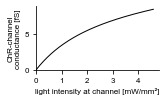

In [7]:
fig, ax = plt.subplots(figsize=(pw/3,pl/8))
data.plot(x='light_intensity_mWPERmm2', y='mean_g_per_ChRchannel_fS', ax=ax, c='black',lw=1)
ax.set_ylim(0,None)
ax.set_xlim(0,None)
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('ChR-channel\nconductance [fS]')
ax.set_xlabel('light intensity at channel [mW/mm²]')
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/appendix_condVSintensity_singleChR.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()